purpose: reimplement OpenBox method and extend it for CNN

In [1]:
from torch import nn
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchvision import datasets, transforms, utils
from src.utility import convert_image_np
import tqdm
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import gridspec
from lib.data import Mimic2

In [2]:
def to_var(x, *args, **kwargs):
    if type(x) is list or type(x) is tuple:
        x = [Variable(x_, *args, **kwargs) for x_ in x]
    else:
        x = Variable(x, *args, **kwargs)
    return x

def show_tensor_image(images_batch):
    grid = utils.make_grid(images_batch)   
    plt.imshow(convert_image_np(grid))
    plt.gca().grid(False)
    plt.show()
    
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=1000, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (x, y) in enumerate(trainloader):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            x, y = to_var(x), to_var(y)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

def show_acc(net, loader, name=""):
    net.eval()
    correct = 0
    total = 0

    for data in loader:
        x, y = data
        x, y = to_var(x), to_var(y)
        outputs = net(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y.data).sum()

    print('Accuracy of the network on %d %s images: %d %%' % (len(loader.sampler), name, 100 * correct / total))

# fully connected network with ReLu activation

In [3]:
class MLP(nn.Module):

    def __init__(self, neuron_sizes): # using relu activation
        super(MLP, self).__init__()
        self.neuron_sizes = neuron_sizes
        
        layers = []
        for s0, s1 in zip(neuron_sizes[:-1], neuron_sizes[1:]):
            layers.extend([
                nn.Linear(s0, s1),
                nn.ReLU(inplace=True)
            ])
        
        self.classifier = nn.Sequential(*layers[:-1])
        
    def forward(self, x):
        x = x.view(-1, self.neuron_sizes[0])
        return self.classifier(x)

net = MLP(neuron_sizes=[784, 8, 2, 2])
net

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=8, out_features=2, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [4]:
'''
todo: make a recursive definition of open_box to account for residue connection

current implementation can be made more efficient by memoization of bottom up search through the network
'''

# assumes has an attribute called classifier with sequential layers
def open_box(model, x): 
    # forward pass to determine configuration
    # assume x is flat with no batch dimension
    assert len(x.shape) == 1, "assume no batch dimension in input"
    d = x.shape[0]
    C = []
    
    # get W and b
    W = to_var(torch.eye(d))
    b = to_var(torch.zeros(d))
    z = x
    
    for i, c in enumerate(model.classifier):
        if type(c) == torch.nn.modules.linear.Linear:
            W = torch.mm(c.weight, W)
            b = c.bias + torch.mv(c.weight, b)
        elif type(c) == torch.nn.modules.ReLU:
            C.extend(list((z > 0).int().data.numpy())) # configuration
            r = (z > 0).float() # the slope
            t = torch.zeros_like(z) # the bias
            W = torch.mm(torch.diag(r), W)
            b = t + torch.mv(torch.diag(r), b)
            
        z = c(z) # forward pass
    
    C = ''.join(map(str, C))
    return W, b, C

checking if it is exact
min: 0.000000, mean: 0.000000, max: 0.000000


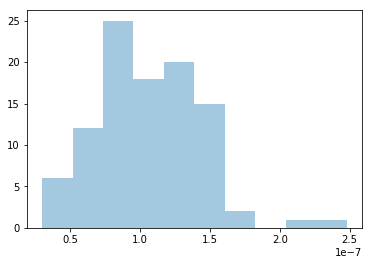

In [5]:
def abs_diff(a, b):
    return torch.abs(a - b).sum().data.numpy()

def diff_check(net, num_runs=100):
    diff = []
    d = net.classifier[0].in_features
    for i in range(num_runs):
        x = to_var(torch.randn(d))
        W, b, C = open_box(net, x)
        diff.append(abs_diff(torch.mv(W, x) + b, net(x)))
    return diff

diff = diff_check(MLP([100,50,30,20,10]))
sns.distplot(diff, kde=False)
print('checking if it is exact')
print('min: %f, mean: %f, max: %f' % (np.min(diff), np.mean(diff), np.max(diff)))

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


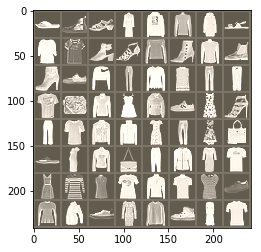

[1,   400] loss: 0.5978858159
[1,   800] loss: 0.4750004226
[2,   400] loss: 0.4446145136
[2,   800] loss: 0.4421571838
[3,   400] loss: 0.4175592046
[3,   800] loss: 0.4323705256
[4,   400] loss: 0.4148367860
[4,   800] loss: 0.4160445024
[5,   400] loss: 0.4171274393
[5,   800] loss: 0.4098763291
[6,   400] loss: 0.4021511416
[6,   800] loss: 0.4101941074
[7,   400] loss: 0.3971678761
[7,   800] loss: 0.4086088153
[8,   400] loss: 0.3989395015
Finished Training in 50s


In [6]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

net = MLP(neuron_sizes=[784, 10])
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)

x, y = next(iter(train_loader))
show_tensor_image(x)

train(net, train_loader, criterion, optimizer, print_every=400, epochs=10, max_time=50)

In [7]:
show_acc(net, test_loader)

Accuracy of the network on 10000  images: 84 %


In [8]:
def getAvgImg(loader, criteria=lambda x: True):
    res = 0
    count = 0
    for x, y in loader:
        for i, im in enumerate(x):
            if criteria(y[i]):
                count += 1
                res += im
    return (res / count).numpy().reshape(28,28)

avg_images = []
for i in tqdm.tqdm(range(10)):
    im = getAvgImg(train_loader, criteria=lambda y: y == i)
    avg_images.append(im)

100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


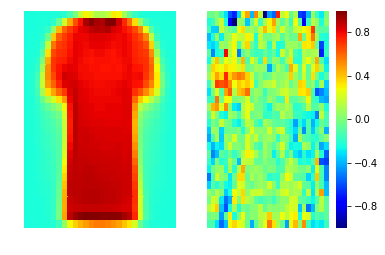

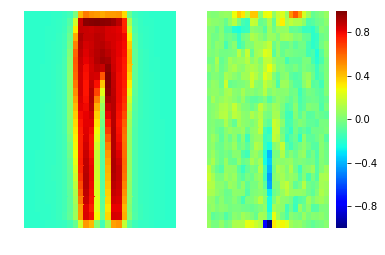

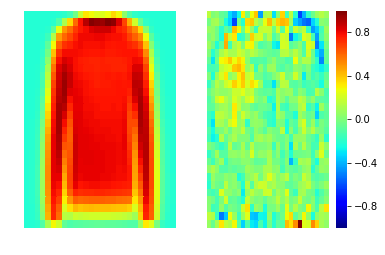

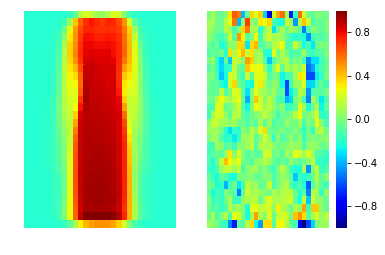

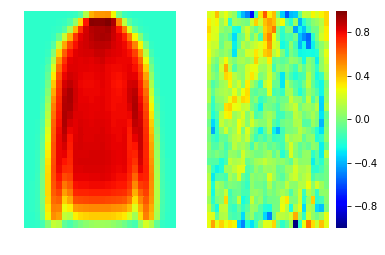

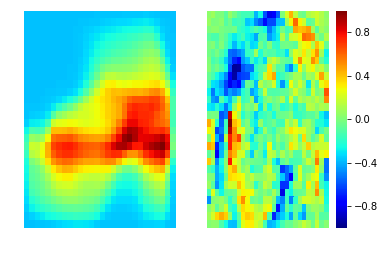

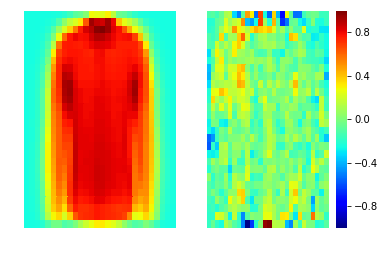

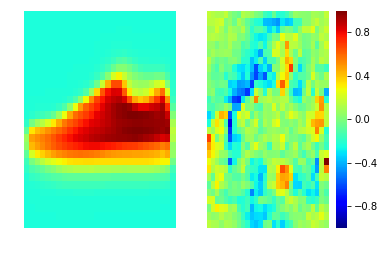

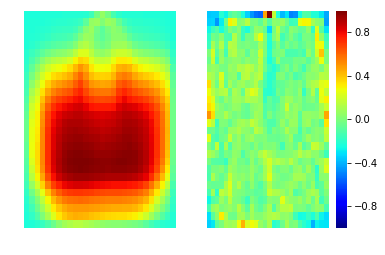

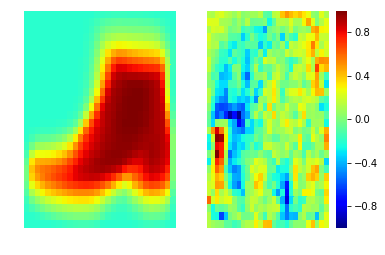

In [9]:
# visualization
def scale_figure(im): # scale activation to -1 to 1
    im = im / np.abs(im).max()
    return im

W, b, C = open_box(net, x[0].view(784))
for i in range(10):
    plt.subplot(121)
    im = scale_figure(avg_images[i])
    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')
    
    plt.subplot(122)
    w = W[i] - W.mean(0)
    im = scale_figure(w.data.numpy().reshape(28,28))
    sns.heatmap(im, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')

    plt.show()



In [14]:
def count_config(net, loader):
    counter = defaultdict(int)
    for x, y in tqdm.tqdm(loader):
        for i, im in enumerate(x):
            W, b, C = open_box(net, im.view(-1))
            counter[C] += 1
    return counter

# Fashion MNIST Binary Case (Paper Replication)

Lesson learned: multiple class explanation is hard to learn (could be one of future direction), first focus on binary cases



0it [00:00, ?it/s]

361it [00:00, 3578.29it/s]

822it [00:00, 4092.40it/s]

1367it [00:00, 4542.83it/s]

1820it [00:00, 4521.85it/s]

2368it [00:00, 4724.08it/s]

2806it [00:00, 4655.67it/s]

3272it [00:00, 4659.02it/s]

3706it [00:00, 4573.84it/s]

4130it [00:00, 4467.67it/s]

4538it [00:01, 4344.55it/s]

4972it [00:01, 4340.81it/s]

5390it [00:01, 4328.90it/s]

5906it [00:01, 4390.58it/s]

6461it [00:01, 4471.35it/s]

6935it [00:01, 4455.15it/s]

7394it [00:01, 4450.99it/s]

7848it [00:01, 4389.79it/s]

8274it [00:01, 4352.90it/s]

8685it [00:02, 4340.61it/s]

9096it [00:02, 4326.26it/s]

9505it [00:02, 4295.63it/s]

9903it [00:02, 4279.05it/s]

10299it [00:02, 4256.39it/s]

10817it [00:02, 4293.10it/s]

11403it [00:02, 4352.38it/s]

11921it [00:02, 4383.53it/s]

12488it [00:02, 4428.77it/s]

13050it [00:02, 4469.33it/s]

13606it [00:03, 4505.78it/s]

14142it [00:03, 4496.71it/s]

14747it [00:03, 4544.43it/s]

15300it [00:03, 4573.85it/s]

15897it [00:03, 4614.25it/s]

16517it [00:

tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0])


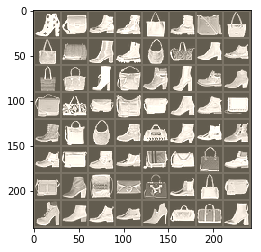

In [13]:
batch_size = 64

classes = [9, 8]

class SelectClasses():
    
    def __init__(self, classes):
        # remap classes labels
        self.classes = classes
    
    def __call__(self, y):
        num_classes = len(self.classes)
        try:
            return self.classes.index(y)
        except:
            return num_classes

train_data = datasets.FashionMNIST('fmnist_data', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]),
                      target_transform=SelectClasses(classes)
                     )
test_data = datasets.FashionMNIST('fmnist_data', train=False, 
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ]),
                     target_transform=SelectClasses(classes)
                    )

train_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(train_data)):
    if y < len(classes):
        train_subset.append(i)

test_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(test_data)):
    if y < len(classes):
        test_subset.append(i)        
        
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_subset))

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_subset))

x, y = next(iter(train_loader))
print(y)
show_tensor_image(x)

In [15]:
fmnist1 = MLP(neuron_sizes=[784, 8, 2, 2])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fmnist1.parameters(), weight_decay=1e-4)
train(fmnist1, train_loader, criterion, optimizer, print_every=100, epochs=10, max_time=50)

[1,   100] loss: 0.3432323629
[2,   100] loss: 0.2252501599
[3,   100] loss: 0.1712360945
[4,   100] loss: 0.1331043033
[5,   100] loss: 0.1074003682
[6,   100] loss: 0.0850443337
[7,   100] loss: 0.0696220510
[8,   100] loss: 0.0597369673
[9,   100] loss: 0.0493274460
[10,   100] loss: 0.0423585077
Finished Training in 16s


In [16]:
show_acc(fmnist1, test_loader)

Accuracy of the network on 2000  images: 99 %




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:00<00:35,  5.33it/s]

  1%|          | 2/188 [00:00<00:33,  5.52it/s]

  2%|▏         | 3/188 [00:00<00:31,  5.90it/s]

  2%|▏         | 4/188 [00:00<00:31,  5.89it/s]

  3%|▎         | 5/188 [00:00<00:30,  6.02it/s]

  3%|▎         | 6/188 [00:00<00:29,  6.16it/s]

  4%|▎         | 7/188 [00:01<00:29,  6.23it/s]

  4%|▍         | 8/188 [00:01<00:29,  6.03it/s]

  5%|▍         | 9/188 [00:01<00:29,  6.14it/s]

  5%|▌         | 10/188 [00:01<00:29,  6.11it/s]

  6%|▌         | 11/188 [00:01<00:30,  5.87it/s]

  6%|▋         | 12/188 [00:02<00:29,  5.91it/s]

  7%|▋         | 13/188 [00:02<00:29,  5.93it/s]

  7%|▋         | 14/188 [00:02<00:29,  5.91it/s]

  8%|▊         | 15/188 [00:02<00:29,  5.88it/s]

  9%|▊         | 16/188 [00:02<00:29,  5.85it/s]

  9%|▉         | 17/188 [00:02<00:29,  5.88it/s]

 10%|▉         | 18/188 [00:03<00:28,  5.90it/s]

 10%|█         | 19/188 [00:03<00:28,  5.93it/s]

 11%|█         |

 77%|███████▋  | 145/188 [00:26<00:07,  5.44it/s]

 78%|███████▊  | 146/188 [00:26<00:07,  5.44it/s]

 78%|███████▊  | 147/188 [00:27<00:07,  5.44it/s]

 79%|███████▊  | 148/188 [00:27<00:07,  5.44it/s]

 79%|███████▉  | 149/188 [00:27<00:07,  5.44it/s]

 80%|███████▉  | 150/188 [00:27<00:06,  5.44it/s]

 80%|████████  | 151/188 [00:27<00:06,  5.43it/s]

 81%|████████  | 152/188 [00:27<00:06,  5.44it/s]

 81%|████████▏ | 153/188 [00:28<00:06,  5.43it/s]

 82%|████████▏ | 154/188 [00:28<00:06,  5.43it/s]

 82%|████████▏ | 155/188 [00:28<00:06,  5.43it/s]

 83%|████████▎ | 156/188 [00:28<00:05,  5.42it/s]

 84%|████████▎ | 157/188 [00:28<00:05,  5.42it/s]

 84%|████████▍ | 158/188 [00:29<00:05,  5.41it/s]

 85%|████████▍ | 159/188 [00:29<00:05,  5.41it/s]

 85%|████████▌ | 160/188 [00:29<00:05,  5.41it/s]

 86%|████████▌ | 161/188 [00:29<00:04,  5.41it/s]

 86%|████████▌ | 162/188 [00:29<00:04,  5.41it/s]

 87%|████████▋ | 163/188 [00:30<00:04,  5.40it/s]

 87%|████████▋ | 164/188 [00:30

Text(0,0.5,'instances in training set')

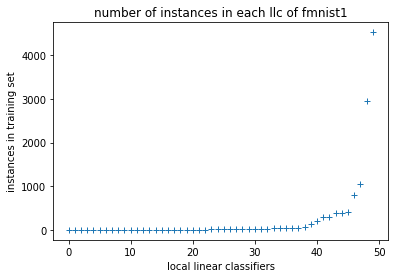

In [18]:
config_counter_fmnist1 = count_config(fmnist1, train_loader)

plt.plot(sorted(config_counter_fmnist1.values() ), '+')
plt.title('number of instances in each llc of fmnist1')
plt.xlabel('local linear classifiers')
plt.ylabel('instances in training set')

In [31]:
# find an instance with config
def find_x(config, net, loader):
    for x, y in loader:
        for i, im in enumerate(x):
            W, b, C = open_box(net, im.view(784))
            if C == config:
                return im

sorted_fmnist1_configs = sorted(config_counter_fmnist1.items(), key=lambda x: x[1], reverse=True)
x = find_x(sorted_fmnist1_configs[2][0], fmnist1, train_loader)

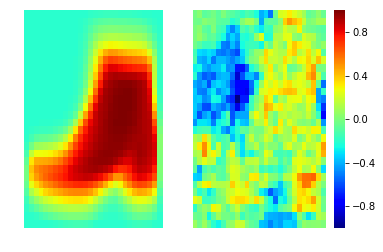

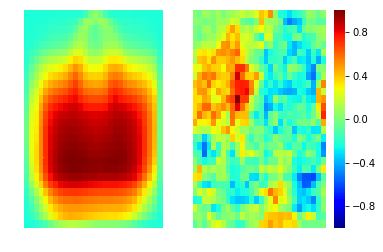

In [32]:
W, b, C = open_box(fmnist1, x.view(784))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 6])

for i in range(2):
    plt.subplot(gs[0])
    im = scale_figure(avg_images[classes[i]])
    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')
    
    plt.subplot(gs[1])
    j = 0 if i==1 else 1
    w = W[i] - W[j]
    im = scale_figure(w.data.numpy().reshape(28,28))
    cax = sns.heatmap(im, cmap='jet', vmin=-1, vmax=1, cbar=True)
    plt.gca().axis('off')
    
    plt.show()

In [37]:
avg_images[9].mean(), avg_images[8].mean(), b[1]-b[0]

(0.55337691, 0.72332299, tensor(2.3148, grad_fn=<ThSubBackward>))

# todo: see how many positive cases and negative cases in each polytope

In [229]:
sum(list(config_counter_fmnist1.values())), 2**10

(12000, 1024)

# OpenBoxFCN + EYE on MIMIC2 

In [6]:
Mimic2()